In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
pip install micrograd

Note: you may need to restart the kernel to use updated packages.


In [54]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def f(x):
    return 3*x**2 -4*x +5

In [56]:
f(3.0)

20.0

In [57]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

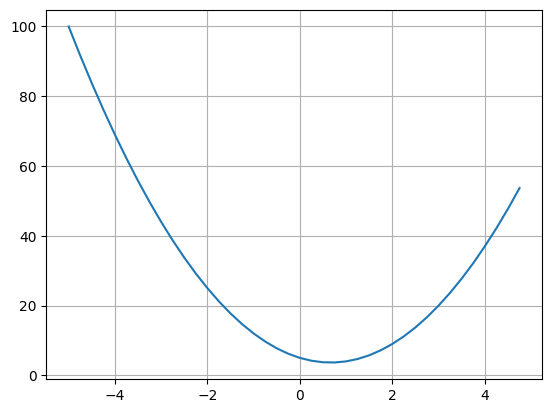

In [58]:
ys=f(xs)
plt.plot(xs,ys)
plt.grid()

In [59]:
h=0.001
x=3.0
f(x+h)

20.014003000000002

In [60]:
def derivative(x,h=0.000001):
    return (f(x+h)-f(x))/h

In [61]:
derivative(2/3)

2.999378523327323e-06

In [62]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [63]:
h=0.000001
a=2.0
b=-3.0
c=10.0
d1=a*b+c  
a+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [64]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self._backward=lambda :None
        self.label=label
        self.grad=0.0
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            #self.grad=1.0*out.grad#bug
            #other.grad=1.0*out.grad#bug
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    def __rmul__(self,other):
        return self*other
    def __truediv__(self,other):
        return self*other**-1
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out=Value(self.data**other,(self,),f'**{other}')
        def backward():
            self.grad+=(other*self.data**(other-1))*out.grad
        out._backward=_backward
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0,label='f')
L=d*f;L.label="L"

In [65]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [66]:
d._op

'+'

In [67]:
from graphviz import Digraph
def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot=Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{%s |data %.4f|grad %.4f}"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

In [68]:
trace(d)

({Value(data=-3.0),
  Value(data=-6.0),
  Value(data=10.0),
  Value(data=2.0),
  Value(data=4.0)},
 {(Value(data=-3.0), Value(data=-6.0)),
  (Value(data=-6.0), Value(data=4.0)),
  (Value(data=10.0), Value(data=4.0)),
  (Value(data=2.0), Value(data=-6.0))})

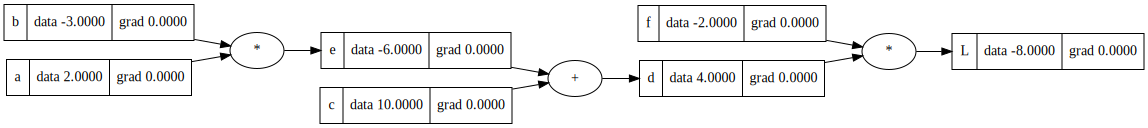

In [69]:
draw_dot(L)

L=d*f
dl/dd=? f
(f(x+h)-f(x))/h
((d+h)*f-d*f)/h
(d*f+h*f-d*f)/h
(h*f)/h
f

In [70]:
# L.grad=1.0
# f.grad=4.0
# d.grad=-2.0
# e.grad=-2.0
# c.grad=-2.0
# a.grad=6.0
# b.grad=-4.0

In [71]:
a.data+=0.001*a.grad
b.data+=0.001*b.grad
c.data+=0.001*c.grad
f.data+=0.001*f.grad

e=a*b
d=e+c
L=d*f
print(L.data)

-8.0


In [72]:
def lol():
    h=0.001
    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label="L"
    L1=L.data

    a=Value(2.0,label='a')
    b=Value(-3.0+h,label='b')
    c=Value(10.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label="L"
    L2=L.data
    print((L2-L1)/h)
lol()    

-3.9999999999995595


dL/dc=(dd/dc)*(dL/dd)

dd/dc=1

dL/dd=-2.0
dL/dc=-2
dl/de=dd/de*dL/dd=-2.0
dd/de=1


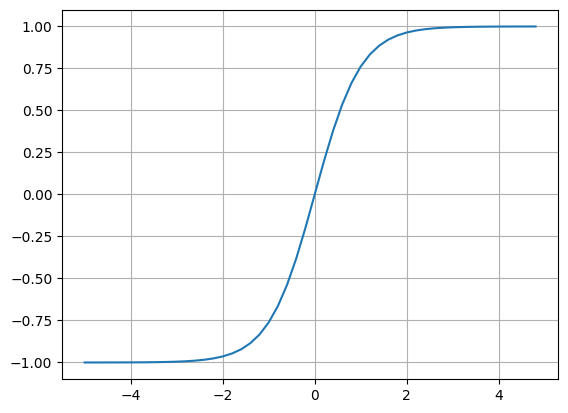

In [73]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid();

In [74]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
b=Value(6.88137353 ,label='b')
x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1x2w2'
n=x1w1x2w2 +b;n.label='n'
func=n.tanh();func.label='o'

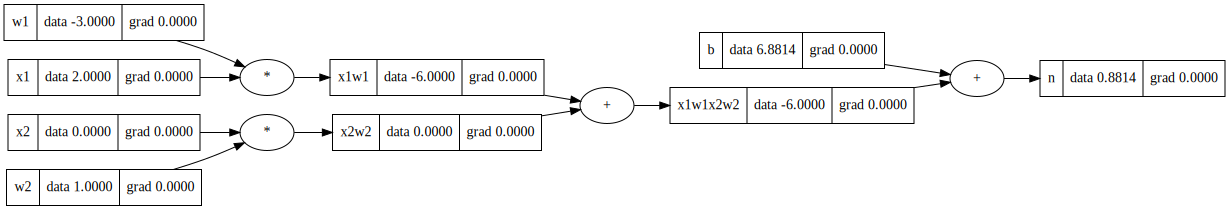

In [75]:
draw_dot(n)

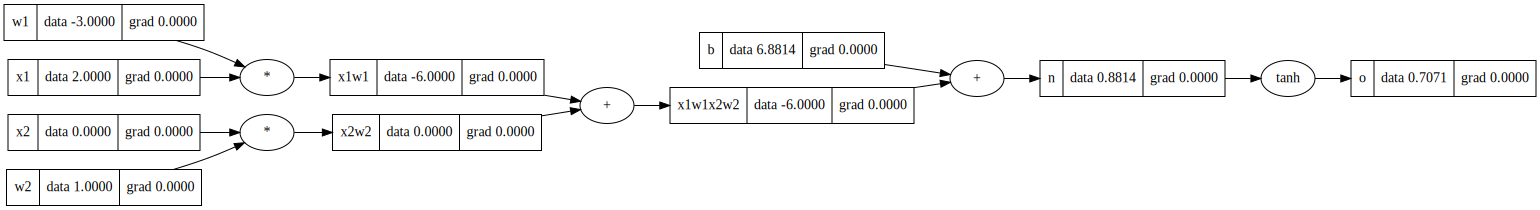

In [76]:
draw_dot(func)

In [77]:
# func.grad=1.0
# n.grad=0.5
# x1w1x2w2.grad=0.5
# b.grad=0.5
# x1w1.grad=0.5
# x2w2.grad=0.5
# x2.grad=0.5
# w2.grad=0.0
# x1.grad=-1.5
# w1.grad=1.0

# func.grad=0.0
n.grad=0.0
x1w1x2w2.grad=0.0
b.grad=0.0
x1w1.grad=0.0
x2w2.grad=0.0
x2.grad=0.0
w2.grad=0.0
x1.grad=0.0
w1.grad=0.0

o=tanh(n)
do/dn=1-tanh(n)**2
=1-0.7071**2
=0.4999

In [78]:
func.grad=1.0

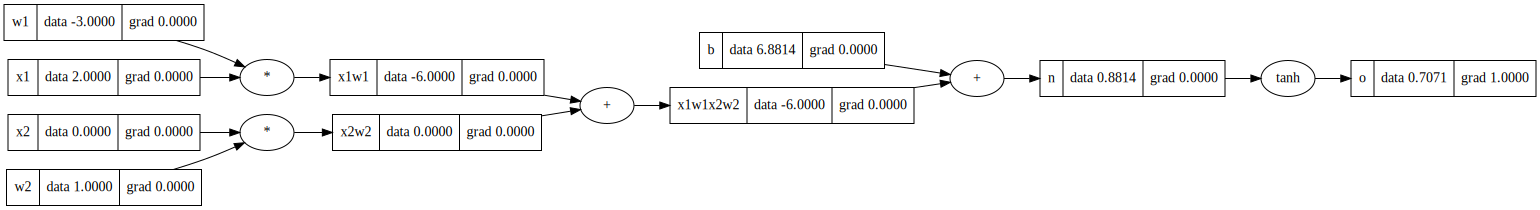

In [79]:
draw_dot(func)

In [80]:
func.backward()

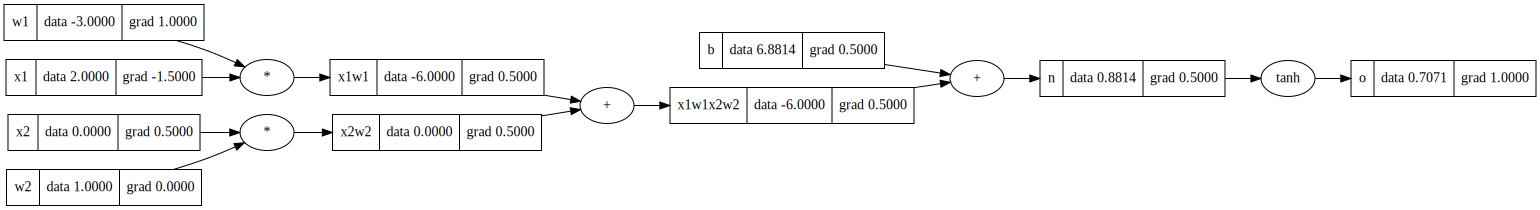

In [81]:
draw_dot(func)

In [82]:
n._backward()

In [83]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [ ]:
draw_dot(func)

In [ ]:
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(func)
topo

In [ ]:
a=Value(3.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)

In [ ]:
a=Value(-2.0,label='a')
b=Value(3.0,label='b')
d=a*b;d.label='d'
e=a+b;e.label='e'
f=d*e;f.label='f'
f.backward()
draw_dot(f)

In [ ]:
import torch
x1=torch.Tensor([2.0]).double()   ;x1.requires_grad=True
x2=torch.Tensor([0.0]).double()   ;x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()  ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double()   ;w2.requires_grad=True
b=torch.Tensor([6.8813735870]).double()  ;b.requires_grad=True
n=x1*w1 + x2*w2 +b
o=torch.tanh(n)

print(o.data.item())
o.backward()
print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

In [92]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [97]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs
x=[2.0,3.0]
n=Layer(2,3)
n(x)

[Value(data=-0.8040151688426384),
 Value(data=0.38608543043812316),
 Value(data=-0.48203754095812285)]

In [94]:
n.b

Value(data=-0.36856412970617525)

In [95]:
n.w

[Value(data=0.6510166754569151), Value(data=0.526482737296005)]